# Network Data Access - USGS NWIS Service-based Data Access

Karl Benedict  
Director, Earth Data Analysis Center  
Associate Professor, University Libraries  
University of New Mexico  
*kbene@unm.edu*

## An Analysis

This analysis demonstrates searching for datasets that meet a set of specified conditions, accessing via advertised services, processing and plotting the data from the service.

Service Documentation: [http://waterservices.usgs.gov/rest/IV-Service.html](http://waterservices.usgs.gov/rest/IV-Service.html)

Enable the needed python libraries

In [1]:
import urllib
import zipfile
import StringIO
import string
import pandas
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
import json

Set some initial variables

In [2]:
county_name = ""
start_date = "20140101"
end_date = "20150101"
diag = False

### Options

In [3]:
## Retrieve the bounding box of the specified county - if no county is specified, the bounding boxes for all NM counties will be requested
countyBBOXlink = "http://gstore.unm.edu/apps/epscor/search/nm_counties.json?limit=100&query=" + county_name  ## define the request URL
print countyBBOXlink ## print the request URL for verification
print
bboxFile = urllib.urlopen(countyBBOXlink) ## request the bounding box information from the server
bboxData = json.load(bboxFile)
# print bboxData

# Get data for BBOX defined by specified county(ies)
myCounties = []
for countyBBOX in bboxData["results"]:
    minx,miny,maxx,maxy = countyBBOX[u'box']
    myDownloadLink = "http://waterservices.usgs.gov/nwis/iv/?bBox=%f,%f,%f,%f&format=json&period=P7D&parameterCd=00060" % (minx,miny,maxx,maxy) # retrieve data for the specified BBOX for the last 7 days as JSON
    print myDownloadLink
    myCounty = {u'name':countyBBOX[u'text'],u'minx':minx,u'miny':miny,u'maxx':maxx,u'maxy':maxy,u'downloadLink':myDownloadLink}
    myCounties.append(myCounty)


http://gstore.unm.edu/apps/epscor/search/nm_counties.json?limit=100&query=

http://waterservices.usgs.gov/nwis/iv/?bBox=-107.196175,34.869022,-106.149574,35.219643&format=json&period=P7D&parameterCd=00060
http://waterservices.usgs.gov/nwis/iv/?bBox=-109.047470,33.200928,-107.711266,34.581020&format=json&period=P7D&parameterCd=00060
http://waterservices.usgs.gov/nwis/iv/?bBox=-105.353912,32.518768,-103.509666,34.088490&format=json&period=P7D&parameterCd=00060
http://waterservices.usgs.gov/nwis/iv/?bBox=-109.046219,34.577576,-107.066689,35.348335&format=json&period=P7D&parameterCd=00060
http://waterservices.usgs.gov/nwis/iv/?bBox=-105.377747,36.217609,-104.007179,36.996243&format=json&period=P7D&parameterCd=00060
http://waterservices.usgs.gov/nwis/iv/?bBox=-103.740021,34.302570,-103.042656,34.954407&format=json&period=P7D&parameterCd=00060
http://waterservices.usgs.gov/nwis/iv/?bBox=-104.893143,33.995411,-103.945618,34.779518&format=json&period=P7D&parameterCd=00060
http://waterservices.

In [4]:
#countySubset = [myCounties[0]]
#print countySubset

valueList = []

for county in myCounties:
    print "processing: %s" % county["downloadLink"]
    try:
        datafile = urllib.urlopen(county["downloadLink"])
        data = json.load(datafile)
        values = data["value"]["timeSeries"][0]["values"]
        for item in values:
            for valueItem in item["value"]:
                #print json.dumps(item["value"], sort_keys=True, indent=4)
                myValue = {"dateTime":valueItem["dateTime"].replace("T"," ").replace(".000-06:00",""),"value":valueItem["value"], "county":county["name"]}
                #print myValue
                valueList.append(myValue)
        #print valueList
    except:
        print "\tfailed for this one ..."
     
    #print json.dumps(values, sort_keys=True, indent=4)

processing: http://waterservices.usgs.gov/nwis/iv/?bBox=-107.196175,34.869022,-106.149574,35.219643&format=json&period=P7D&parameterCd=00060
processing: http://waterservices.usgs.gov/nwis/iv/?bBox=-109.047470,33.200928,-107.711266,34.581020&format=json&period=P7D&parameterCd=00060
processing: http://waterservices.usgs.gov/nwis/iv/?bBox=-105.353912,32.518768,-103.509666,34.088490&format=json&period=P7D&parameterCd=00060
processing: http://waterservices.usgs.gov/nwis/iv/?bBox=-109.046219,34.577576,-107.066689,35.348335&format=json&period=P7D&parameterCd=00060
processing: http://waterservices.usgs.gov/nwis/iv/?bBox=-105.377747,36.217609,-104.007179,36.996243&format=json&period=P7D&parameterCd=00060
processing: http://waterservices.usgs.gov/nwis/iv/?bBox=-103.740021,34.302570,-103.042656,34.954407&format=json&period=P7D&parameterCd=00060
	failed for this one ...
processing: http://waterservices.usgs.gov/nwis/iv/?bBox=-104.893143,33.995411,-103.945618,34.779518&format=json&period=P7D&parame

In [5]:
df = pandas.DataFrame(valueList)

In [6]:
df['dateTime'] = pandas.to_datetime(df["dateTime"])
df['value'] = df['value'].astype(float).fillna(-1)

print df.shape
print df.dtypes
print "column names"
print "------------"
for colName in df.columns:
    print colName
print
print df.head()

(20764, 3)
county              object
dateTime    datetime64[ns]
value              float64
dtype: object
column names
------------
county
dateTime
value

       county            dateTime  value
0  Bernalillo 2015-05-27 08:15:00    1.9
1  Bernalillo 2015-05-27 08:20:00    1.9
2  Bernalillo 2015-05-27 08:25:00    1.9
3  Bernalillo 2015-05-27 08:30:00    1.9
4  Bernalillo 2015-05-27 08:35:00    1.9


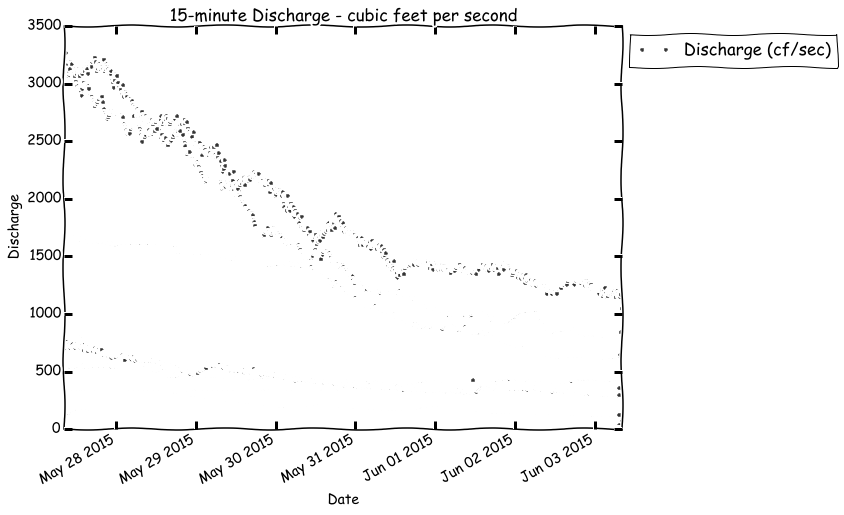

In [9]:
%matplotlib inline
fig,ax = plt.subplots(figsize=(10,8))
ax.width = 1
ax.height = .5
plt.xkcd()
#plt.ylim(-25,30)
ax.plot_date(df['dateTime'], df['value'], '.', label="Discharge (cf/sec)", color="0.2")
fig.autofmt_xdate()
plt.legend(loc=2, bbox_to_anchor=(1.0,1))
plt.title("15-minute Discharge - cubic feet per second")
plt.ylabel("Discharge")
plt.xlabel("Date")
plt.show()